In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc

import xgboost as xgb

In [3]:
tabular_data = pd.read_csv('tabular_data.csv')
hashed_feature = pd.read_csv('hashed_feature.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
tabular_data.nunique()

id             5106
period           12
feature_0         6
feature_1     10233
feature_2     55114
feature_3     32636
feature_4     34599
feature_5     11468
feature_6     56466
feature_7     34986
feature_8      1391
feature_9      8545
feature_10    33635
feature_11    11932
feature_12    55019
feature_13    46800
feature_14      260
feature_15       63
feature_16     1581
feature_17    61272
feature_18    35845
feature_19    54854
feature_20     6402
feature_21     4491
feature_22    11320
feature_23      470
feature_24      272
feature_25        8
feature_26      821
feature_27     3387
feature_28     9032
feature_29     5885
feature_30      980
feature_31     6598
feature_32     1561
feature_33    55179
feature_34      456
feature_35    28620
feature_36    17770
feature_37      452
feature_38     3064
feature_39     2410
feature_40     3552
feature_41        1
feature_42    29756
feature_43       32
feature_44     6395
feature_45      261
feature_46    52989
feature_47      883


In [5]:
hashed_feature.head()

,id,feature_50
0,0,7984b0a0e139cabadb5afc7756d473fb34d23819
1,0,47904b3331202e9881d003ff449c2eabfbc75460
2,0,a99c4b3af723874ddd85af322beea81b64437294
3,0,4dce5381031a88aed6b12ef71b6f7c3148e7b3c8
4,0,d62db721202cb6636887f450a7b77fa97db03b05


In [6]:
# Join number of feature_50 to every id
feature_50 = hashed_feature[['id', 'feature_50']].groupby('id').nunique()
tabular_data = tabular_data.join(feature_50, on='id', how='left')

In [7]:
tabular_data.head()

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50
0,0,1,110.0,55.0,0.432017,0.000000,176.78,0.0,0.323712,NaN,147.0,0.0,176.78,55.0,0.248711,0.001373,0.0,0.0,0.0,0.476549,333.60,0.277617,55.0,0.0,55.0,21.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,1.00,55.000000,93.0,5562.0,93.0,0.040283,182.0,0.000000,43.50,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,2.0,0.526552,145.0,133.28,0.0,10
1,0,2,110.0,110.0,0.397517,0.000000,315.42,0.0,0.316798,NaN,135.0,0.0,315.42,110.0,0.261744,-0.002248,0.0,0.0,0.0,0.210951,428.78,0.290904,110.0,0.0,110.0,26.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.77,110.000000,114.0,5532.0,114.0,0.047588,181.0,0.000000,85.45,0.0,0.0,15.75,0.00,0,0.000000,0.0,110.0,1.0,0.481063,130.0,229.97,0.0,10
2,0,3,110.0,55.0,0.359440,0.000000,354.55,0.0,0.339188,NaN,181.0,0.0,354.48,55.0,0.302164,0.002083,0.0,0.0,0.0,0.058675,526.38,0.284842,55.0,0.0,55.0,36.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.05,85249.281058,135.0,5501.0,136.0,0.051470,180.0,0.000000,122.70,0.0,0.0,0.00,0.07,0,0.000000,0.0,55.0,1.0,0.509598,180.0,231.78,0.0,10
3,0,4,110.0,55.0,0.285707,0.000000,229.98,0.0,0.415428,NaN,142.0,0.0,229.98,55.0,0.347660,0.005207,0.0,0.0,0.0,0.966854,398.98,0.285235,55.0,0.0,55.0,30.0,0.0,f9ae10397ed62e79c644d06842bbcd92963a5927,NaN,0.0,0.00,55.000000,102.0,5471.0,102.0,0.076190,179.0,0.000000,46.15,0.0,0.0,0.00,0.00,0,0.000000,0.0,55.0,0.0,0.680089,142.0,183.83,0.0,10
4,0,5,110.0,55.0,0.101487,444.730391,307.12,0.0,0.569670,NaN,92.0,0.0,306.17,55.0,0.438425,0.025736,0.0,21.0,0.0,0.700180,215.17,0.161147,55.0,0.0,55.0,20.0,0.0,11e623a37e87cf7995c466723ec99688d55cae8c,NaN,0.0,0.00,55.000000,82.0,5440.0,95.0,0.273205,178.0,373.498562,150.33,0.0,0.0,26.75,0.95,0,20.014485,0.0,55.0,0.0,0.776175,85.0,155.83,0.0,10


In [38]:
# Add target
tabular_train = tabular_data.join(train.set_index('id'), on='id', how='left')

# Change NaN on median
median = tabular_train.loc[:, 'feature_0':'feature_49'].median(axis=0)
tabular_train.fillna(median, axis=0, inplace=True)

# one-hot feature_25
dummies_names = ['feature_25_' + str(i) for i in range(tabular_train['feature_25'].nunique())]
dummies_names = dict(zip(tabular_train['feature_25'].unique(), dummies_names))
tabular_train.loc[:, dummies_names.values()] = pd.get_dummies(tabular_train['feature_25']).rename(columns=dummies_names)

tabular_train = tabular_train.drop(columns=['feature_25', 'feature_41'])

tabular_train.loc[:, 'feature_0':'feature_49'] = StandardScaler().fit_transform(tabular_train.loc[:, 'feature_0':'feature_49'])

In [39]:
# Correlation heatmap

# tabular_train.corr().style.background_gradient(cmap='viridis')

In [40]:
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def metrics(y_true, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred > 0.5)
    metrics['precision'] = precision_score(y_true, y_pred > 0.5)
    metrics['recall'] = recall_score(y_true, y_pred > 0.5)
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred > 0.5)

    return metrics

def correlation(data, threshold):
    col_corr = set()
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in data.columns:
                    del data[colname]

In [41]:
# correlation(tabular_train, 0.6)

In [42]:
tabular_train

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,target,feature_25_0,feature_25_1,feature_25_2,feature_25_3,feature_25_4,feature_25_5,feature_25_6,feature_25_7
0,0,1,-0.147883,-0.338504,0.187137,-0.260786,-0.449327,-0.194205,-0.345121,-0.287067,0.162928,-0.169307,-0.407560,-0.150481,-0.364132,-0.559222,-0.125512,-0.748712,-0.147306,-0.080731,-0.178025,0.466747,-0.250820,-0.212978,-0.147645,-0.173793,-0.125845,-0.256600,-0.370961,-0.425721,-0.147171,-0.250456,1.557934,-0.228818,-1.215016,1.385413,-0.17454,-0.378051,-0.188761,-0.197453,-0.098799,-0.190213,-0.158198,-0.355094,-0.247809,-0.459664,0.286517,0.173683,-0.402133,-0.178256,10,0.0,1,0,0,0,0,0,0,0
1,0,2,-0.147883,0.251238,0.139599,-0.260786,-0.179069,-0.194205,-0.354757,-0.287067,0.078293,-0.169307,-0.130782,-0.141358,-0.243990,-0.601788,-0.125512,-0.748712,-0.147306,-0.998850,0.040567,0.589423,0.676753,-0.212978,-0.138221,-0.038669,-0.125845,-0.256600,-0.370961,-0.430903,-0.142477,-0.107351,1.540133,-0.105196,-1.168310,1.370923,-0.17454,-0.086737,-0.188761,-0.197453,0.470966,-0.190213,-0.158198,-0.355094,0.682367,-0.504515,0.165105,0.049951,-0.142725,-0.178256,10,0.0,1,0,0,0,0,0,0,0
2,0,3,-0.147883,-0.338504,0.087133,-0.260786,-0.102791,-0.194205,-0.323553,-0.287067,0.402728,-0.169307,-0.052804,-0.150481,0.128607,-0.550872,-0.125512,-0.748712,-0.147306,-1.525236,0.264716,0.533456,-0.250820,-0.212978,-0.147645,0.231579,-0.125845,-0.256600,-0.370961,-0.447124,7.123784,0.035755,1.521739,0.024312,-1.143487,1.356432,-0.17454,0.171940,-0.188761,-0.197453,-0.098799,-0.184384,-0.158198,-0.355094,-0.247809,-0.504515,0.241265,0.462394,-0.137869,-0.178256,10,0.0,1,0,0,0,0,0,0,0
3,0,4,-0.147883,-0.338504,-0.014464,-0.260786,-0.345622,-0.194205,-0.217303,-0.287067,0.127663,-0.169307,-0.301353,-0.150481,0.547993,-0.514147,-0.125512,-0.748712,-0.147306,1.614154,-0.027872,0.537084,-0.250820,-0.212978,-0.147645,0.069430,-0.125845,-0.256600,-0.370961,-0.448250,-0.147171,-0.189125,1.503938,-0.175837,-0.985431,1.341942,-0.17454,-0.359649,-0.188761,-0.197453,-0.098799,-0.190213,-0.158198,-0.355094,-0.247809,-0.549366,0.696313,0.148937,-0.266513,-0.178256,10,0.0,1,0,0,0,0,0,0,0
4,0,5,-0.147883,-0.338504,-0.268301,-0.220220,-0.195249,-0.194205,-0.002348,-0.287067,-0.224984,-0.169307,-0.149249,-0.150481,1.384673,-0.272813,-0.125512,0.761726,-0.147306,0.692315,-0.450013,-0.608628,-0.250820,-0.212978,-0.147645,-0.200818,-0.125845,-0.256600,-0.370961,-0.448250,-0.147171,-0.325417,1.485544,-0.217044,0.274253,1.327452,-0.12817,0.363811,-0.188761,-0.197453,0.868896,-0.111109,-0.150839,-0.355094,-0.247809,-0.549366,0.952769,-0.321248,-0.341634,-0.178256,10,0.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61267,5105,8,-0.147883,-0.102608,-0.204894,-0.260786,-0.608160,-0.194205,-0.664722,-0.382230,-1.184185,-0.169307,-0.570963,-0.146832,-1.782792,-0.553729,-0.125512,-0.748712,-0.147306,-1.283447,-0.420823,1.061024,0.086479,-0.175611,-0.143875,-0.444041,-0.125845,-0.436094,-0.370961,-0.448250,-0.145379,-0.482152,0.229999,-0.423080,-1.336120,0.327625,-0.17454,-0.603950,-0.188761,6.063531,0.119340,-0.190213,-0.158198,-0.355094,0.090437,-0.549366,-0.899666,-0.667701,-0.534426,-0.178256,3,NaN,0,0,0,1,0,0,0,0
61268,5105,9,-0.147883,-0.102608,-0.204894,-0.260786,-0.673327,-0.194205,-0.648699,-0.097609,-0.507102,-0.169

In [43]:
train_data = tabular_train.loc[~tabular_train.target.isna()].drop(['target'], axis=1)
target_data = tabular_train.target.dropna()
test_data = tabular_train.loc[tabular_train.target.isna()].drop(['target'], axis=1)

In [44]:
target_data.value_counts()

0.0    36108
1.0    12900
Name: target, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_data, 
                                                    target_data, 
                                                    test_size=0.15,
                                                    random_state=42)

In [46]:
scale_pos_weight = target_data.value_counts()[0] / target_data.value_counts()[1]

eval_set = [(X_train, y_train), (X_test, y_test)]
param = {'max_depth': 6,
         'subsample': 0.8,  
         'eta': 0.1, 
         'min_child_weight': 10,
         'n_estimators' : 100,
         'gamma': 2, 
         'silent': 1,
         'colsample_bytree': 0.6,
         'objective': 'binary:logistic',
         'scale_pos_weight': scale_pos_weight} 

num_round = 100
xgb_cls = xgb.XGBClassifier(**param)
xgb_cls.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.1, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.7990697674418605,
              seed=None, silent=1, subsample=0.8, verbosity=1)

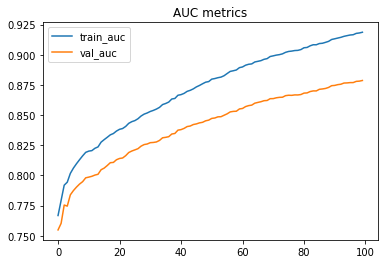

In [47]:
plt.title("AUC metrics")
plt.plot(xgb_cls.evals_result()['validation_0']['auc'], label='train_auc')
plt.plot(xgb_cls.evals_result()['validation_1']['auc'], label='val_auc')
plt.legend()
plt.show()

In [49]:
eval_preds = xgb_cls.predict_proba(X_test)
print(metrics(y_test, eval_preds[:, 1]))


{'accuracy': 0.8022306855277476, 'precision': 0.5933412604042806, 'recall': 0.7776623376623376, 'roc_auc': 0.7943038056470892}

{'accuracy': 0.8022306855277476, 'precision': 0.5933412604042806, 'recall': 0.7776623376623376, 'roc_auc': 0.7943038056470892}


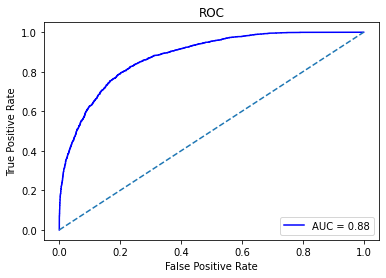

In [50]:
plot_roc_auc(y_test, eval_preds)

In [82]:
result = xgb_cls.predict(test_data.drop_duplicates(subset=['id']))

In [90]:
test['score'] = result
test.to_csv('./drive/My Drive/BigData/test.csv')

In [51]:
# LogisticRegression test

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

class_w0 = target_data.value_counts()[0] / target_data.count()
class_w1 = target_data.value_counts()[1] / target_data.count()

logreg = LogisticRegression(penalty='elasticnet', solver='saga',
                            l1_ratio=0.3, max_iter=100,
                            class_weight={0: class_w0,
                                          1: class_w1}, 
                            n_jobs=-1)

rfe = RFE(logreg, 30)
rfe = rfe.fit(X_train, y_train)
rfe_preds = rfe.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

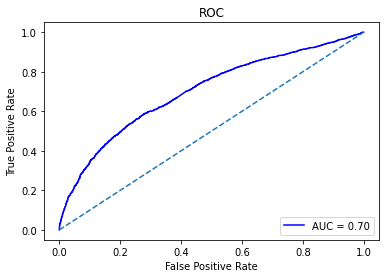

In [52]:
plot_roc_auc(y_test, rfe_preds)

In [53]:
# Neural Network test

import tensorflow as tf
from tensorflow.keras import layers

def create_model(input_shape, lr=0.001, drop_rate=0.2):
  model = tf.keras.Sequential([
                               layers.Input(shape=input_shape),
                               layers.Dense(64, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(64, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(64, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(32, activation='relu'),
                               layers.Dropout(drop_rate),
                               layers.Dense(1, activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [54]:
input_shape = X_train.shape[1]
model = create_model(input_shape)

num_epochs = 10
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, 
                    batch_size=40, 
                    validation_split=0.2,
                    class_weight={0: 1-y_train.mean(),
                                  1: y_train.mean()}
                    )

Epoch 1/10
834/834 [==============================] - 2s 3ms/step - loss: 1.5053 - accuracy: 0.6812 - val_loss: 0.6011 - val_accuracy: 0.7318
Epoch 2/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5918 - accuracy: 0.7345 - val_loss: 0.5815 - val_accuracy: 0.7318
Epoch 3/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5812 - accuracy: 0.7365 - val_loss: 0.5805 - val_accuracy: 0.7318
Epoch 4/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5769 - accuracy: 0.7372 - val_loss: 0.5819 - val_accuracy: 0.7318
Epoch 5/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5765 - accuracy: 0.7373 - val_loss: 0.5815 - val_accuracy: 0.7318
Epoch 6/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5763 - accuracy: 0.7373 - val_loss: 0.5820 - val_accuracy: 0.7318
Epoch 7/10
834/834 [==============================] - 2s 3ms/step - loss: 0.5770 - accuracy: 0.7371 - val_loss: 0.5815 - val_accuracy: 0.7318
Epoch 

In [55]:
print(metrics(y_test, model.predict(X_test)))

{'accuracy': 0.7381664853101197, 'precision': 0.0, 'recall': 0.0, 'roc_auc': 0.5}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
